<a href="https://colab.research.google.com/github/yesimcebeci/Movie-Recommender-System/blob/main/Movie_Recommender_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Importing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Project/ml-latest-small/movies.csv"
movies = pd.read_csv(path)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
path = "/content/drive/MyDrive/Project/ml-latest-small/ratings.csv"
ratings = pd.read_csv(path)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings['movieId'].isna().sum()

0

In [ ]:
rated_movie = ratings.groupby('movieId').userId.count().rename('rated_movie')
mean_rating = ratings.groupby('movieId').rating.mean().rename('mean_rating')

df_ = pd.merge(movies, rated_movie, how='left', on='movieId')
df_ = pd.merge(df_, mean_rating, how='left', on='movieId')

df_['rated_movie'].fillna(0, inplace=True)
df_['mean_rating'].fillna(0, inplace=True)

df_['rated_movie'] = df_['rated_movie'].astype(int)

df_[['title','mean_rating','rated_movie']]

,title,mean_rating,rated_movie
0,Toy Story (1995),3.920930,215
1,Jumanji (1995),3.431818,110
2,Grumpier Old Men (1995),3.259615,52
3,Waiting to Exhale (1995),2.357143,7
4,Father of the Bride Part II (1995),3.071429,49
...,...,...,...
9737,Black Butler: Book of the Atlantic (2017),4.000000,1
9738,No Game No Life: Zero (2017),3.500000,1
9739,Flint (2017),3.500000,1
9740,Bungo Stray Dogs: Dead Apple (2018),3.500000,1


In [ ]:
df = pd.merge(ratings,df_, how='left', on = 'movieId')
df.drop(columns = 'timestamp' , inplace = True)
df

,userId,movieId,rating,title,genres,rated_movie,mean_rating
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215,3.920930
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,52,3.259615
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,102,3.946078
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,203,3.975369
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,204,4.237745
...,...,...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),Drama|Horror|Thriller,6,3.333333
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller,7,4.142857
100833,610,168250,5.0,Get Out (2017),Horror,15,3.633333
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,25,4.280000


# Content Based Filtering

Content based recommenders will use data exclusively about the items. For this we need to have a minimal understanding of the users’ preferences, so that we can then recommend new items with similar tags/keywords to those specified (or inferred) by the user.





## Recommendations based on **Popularity** to a New User

In [ ]:
#We can consider the movies which have more than 200 ratings as POPULAR
pop_movies = df_[df_['rated_movie'] >200].sort_values(by= ['mean_rating','rated_movie'], ascending = [False,False]).head(10)
pop_movies[['title','mean_rating']]

,title,mean_rating
277,"Shawshank Redemption, The (1994)",4.429022
2226,Fight Club (1999),4.272936
46,"Usual Suspects, The (1995)",4.237745
224,Star Wars: Episode IV - A New Hope (1977),4.231076
461,Schindler's List (1993),4.225000
898,Star Wars: Episode V - The Empire Strikes Back...,4.215640
257,Pulp Fiction (1994),4.197068
1939,"Matrix, The (1999)",4.192446
314,Forrest Gump (1994),4.164134
510,"Silence of the Lambs, The (1991)",4.161290


- These are the most popular movies which can be recommended to a new user. **Recommendations based on Popularity**

## Recommendations based on **Movie Genre** to a New User

In [ ]:
genre_popularity = (movies.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)

Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: genres, dtype: int64

The genres alone can be used to provide a reasonably good content based recommendation. But before that, I need to analyse some important aspects.

Most popular genres will be a relevant aspect to take into account when building the content based recommender. We want to understand which genres really are relevant when it comes to defining a user’s taste. A reasonable assumption is that it is precisely the unpopular genres that will be more relevant in characterising the user’s taste.

I will be building a fairly simple recommender, based on the movie genres. A fairly common approach is to use a tf-idf vectorizer.

While this approach is more commonly used on a text corpus, it possesses some interesting properties that will be useful in order to obtain a vector representation of the data.

tf-idf will help capture the important genres of each movie by giving a higher weight to the less frequent genres

In [ ]:
from itertools import combinations

# Define a TF-IDF Vectorizer Object.
tfidf_genres = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf_genres.fit_transform(movies['genres'])

print(tfidf_matrix.shape)

(9742, 783)


In [ ]:
# I've encoded each movie's genre into its tf-idf representation (only a subset of the columns and rows is sampled)
pd.DataFrame(tfidf_matrix.todense(), columns=tfidf_genres.get_feature_names(), index=movies.title).sample(5, axis=1).sample(10, axis=0)

,"(Film-Noir, Mystery, Western)","(Action, Animation, Comedy)","(Comedy, Film-Noir, Thriller)","(Action, Crime, Mystery)","(Action, Animation, Musical)"
title,,,,,
Reversal of Fortune (1990),0.0,0.0,0.0,0.0,0.0
Campus Man (1987),0.0,0.0,0.0,0.0,0.0
Rose Red (2002),0.0,0.0,0.0,0.0,0.0
Babylon 5: The Legend of the Rangers: To Live and Die in Starlight (2002),0.0,0.0,0.0,0.0,0.0
"Red Balloon, The (Ballon rouge, Le) (1956)",0.0,0.0,0.0,0.0,0.0
Saw (2003),0.0,0.0,0.0,0.0,0.0
Monsieur Ibrahim (Monsieur Ibrahim et les fleurs du Coran) (2003),0.0,0.0,0.0,0.0,0.0
My Name Is Bruce (2007),0.0,0.0,0.0,0.0,0.0
Dune (1984),0.0,0.0,0.0,0.0,0.0


In [ ]:
# Compute the cosine similarity matrix
cosine_sim_movies = cosine_similarity(tfidf_matrix)

cosine_sim_df = pd.DataFrame(cosine_sim_movies, index=movies['title'], columns=movies['title'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).round(2)

Shape: (9742, 9742)


title,The Square (2017),The Man in the Moon (1991),No Man's Land (2001),Half a Loaf of Kung Fu (Dian zhi gong fu gan chian chan) (1980),Intermission (2003)
title,,,,,
Toy Story (1995),0.00,0.00,0.00,0.03,0.02
Jumanji (1995),0.00,0.00,0.00,0.00,0.00
Grumpier Old Men (1995),0.00,0.35,0.00,0.15,0.08
Waiting to Exhale (1995),0.22,0.58,0.06,0.09,0.23
Father of the Bride Part II (1995),0.00,0.00,0.00,0.37,0.20
...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.00,0.00,0.00,0.29,0.02
No Game No Life: Zero (2017),0.00,0.00,0.00,0.06,0.03
Flint (2017),1.00,0.38,0.28,0.00,0.19


In [ ]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 10 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = movies.loc[movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the cosine similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 10 most similar movies
    return pd.DataFrame(movies[['title','genres']].iloc[movie_indices])

In [ ]:
movies[movies.title.eq('Pulp Fiction (1994)')]

,movieId,title,genres
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [ ]:
get_recommendations_based_on_genres('Pulp Fiction (1994)')

,title,genres
520,Fargo (1996),Comedy|Crime|Drama|Thriller
791,Freeway (1996),Comedy|Crime|Drama|Thriller
2453,Man Bites Dog (C'est arrivé près de chez vous)...,Comedy|Crime|Drama|Thriller
3155,Beautiful Creatures (2000),Comedy|Crime|Drama|Thriller
4169,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
4523,Party Monster (2003),Comedy|Crime|Drama|Thriller
6676,In Bruges (2008),Comedy|Crime|Drama|Thriller
7129,"Informant!, The (2009)",Comedy|Crime|Drama|Thriller
7293,Leaves of Grass (2009),Comedy|Crime|Drama|Thriller
19,Money Train (1995),Action|Comedy|Crime|Drama|Thriller


In [ ]:
movies[movies.title.eq('Toy Story (1995)')]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
get_recommendations_based_on_genres('Toy Story (1995)')

,title,genres
1706,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2809,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3000,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3568,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
6194,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
6486,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
6948,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy
7760,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy
8219,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy


Let's look at the pros and cons of using content-based recommendation.

**Pros:**
- No need for data on other users, thus no cold-start or sparsity problems.
- Can recommend to users with unique tastes.
- Can recommend new & unpopular items.
- Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)

**Cons:**
- Finding the appropriate features is hard.
- Does not recommend items outside a user’s content profile.
- Unable to exploit quality judgments of other users.

# Collaborative Filtering

Types of **collaborative filtering** techniques

Memory based
- User-Item Filtering (or User-Based Filtering)
- Item-Item Filtering (or Item-Based Filtering)

Model based
- Matrix Factorization
- Clustering
- Deep Learning

The main idea behind these methods is to use other users’ preferences and taste to recommend new items to a user. The usual procedure is to find similar users (or items) to recommend new items which where liked by those users, and which presumably will also be liked by the user being recommended.


In this part, I will use 2 different methods for collaborative filtering. In the first method,I will use the weighted average of the ratings for item-based filtering then I will implement the second method using model-based collaborative approaches like KNN (K nearest neighbors)and SVD (Singular Value Decomposition) for user-based filtering




## Memory Based

They are called memory-based because the algorithm is not complicated, but requires a lot of memory to keep track of the results.

## Item-Based Collaborative Filtering

Item-based collaborative filtering is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings of those items.

It is quite similar to user-based algorithm, but instead of finding user’s look-alike, we try finding movie’s look-alike. Once we have movie’s look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.

In [ ]:
df

,userId,movieId,rating,title,genres,rated_movie,mean_rating
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215,3.920930
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,52,3.259615
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,102,3.946078
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,203,3.975369
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,204,4.237745
...,...,...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),Drama|Horror|Thriller,6,3.333333
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller,7,4.142857
100833,610,168250,5.0,Get Out (2017),Horror,15,3.633333
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,25,4.280000


In [ ]:
# I need to create the user-item matrix. This is essentially a pivoted table from the rating data,
# where the rows will be the users, the columns will be the movies and the dataframe is filled with the rating the user has given (if it exists , 0 otherwise):

ratings_matrix = df.pivot_table(index=['userId'],columns=['title'],values='rating').reset_index(drop=True)

# I need to replace the NULL values by 0s since the cosine_similarity doesn’t work will NA values 
ratings_matrix.fillna( 0, inplace = True )
ratings_matrix.iloc[:20,:10]


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- **ratings_matrix** dataframe is indexed by user_ids with movie_ids belonging to different columns and the values are the ratings with most of the values as 0 as each user watches and rates only few movies. Its a sparse dataframe.

In [ ]:
ratings_matrix.shape

(610, 9719)

In [ ]:
# I will use the weighted avg of the ratings using cosine similarity as the weights
# the item-similarity matrix will measure the similarity between any two pairs of items(movies).
movie_sim = cosine_similarity(ratings_matrix.T)
print('movie similarity shape:' ,movie_sim.shape)


movie similarity shape: (9719, 9719)


In [ ]:
# the similarity between any two pairs of items
movie_sim_df = pd.DataFrame(movie_sim)
movie_sim_df.iloc[:10,:20].round(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.142,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.285,0.000,0.000,0.000
1,0.000,1.000,0.707,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.716,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.707,1.000,0.000,0.000,0.0,0.177,0.000,0.000,0.000,0.707,0.506,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,1.000,0.857,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.645,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.857,1.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.553,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.243,0.000,0.000,0.000,0.000
6,0.000,0.000,0.177,0.000,0.000,0.0,1.000,0.071,0.100,0.248,0.250,0.032,0.000,0.0,0.000,0.000,0.000,0.000,0.180,0.000
7,0.000,0.000,0.000,0.000,0.000,0.0,0.071,1.000,0.000,0.000,0.000,0.447,0.000,0.0,0.000,0.000,0.000,0.000,0.093,0.000
8,0.142,0.000,0.000,0.000,0.000,0.0,0.100,0.000,1.000,0.156,0.000,0.000,0.162,0.0,0.051,0.098,0.174,0.125,0.326,0.101
9,0.000,0.000,0.000,0.000,0.000,0.0,0.248,0.000,0.156,1.000,0.000,0.000,0.000,0.0,0.143,0.276,0.051,0.000,0.089,0.285


In [ ]:
# Below function will take the movie name as a input and will find the movies which are similar to this movie. 
# This function first find the index of movie in movies frame and then take the similarity of movie and align in movies dataframe 
# so that we can get the similarity of the movie with all other movies.

def movie_similarity(movieName):

    
        #Enter the reference movie title based on which recommendations are to be made
        movie_name=movieName
        movie=movies[movies['title']==movie_name].index.tolist()
        movie=movie[0]

        movies2 = movies.copy()
        movies2['similarity'] = movie_sim_df.iloc[movie]
        movies2.columns = ['movieId','title', 'genre','similarity']
        similar_movies = pd.merge(movies2 ,df_[['movieId','rated_movie']].drop_duplicates(), left_index=True, right_on='movieId')
        # similar_movies.columns = ['movieId', 'title' , 'genre' , 'similarity' , 'num_rating']
        similar_movies.set_index('movieId', inplace=True)
        sim_movie = similar_movies.sort_values(by = ['similarity','rated_movie'] , ascending= [False,False])[similar_movies['rated_movie']> 20]
        return sim_movie[['title', 'genre','similarity','rated_movie']][1:11]
        

In [ ]:
movie_similarity('Edward Scissorhands (1990)')

,title,genre,similarity,rated_movie
movieId,,,,
1086,Hamlet (1996),Crime|Drama|Romance,0.880000,25
236,Man of the House (1995),Comedy,0.804984,45
2959,Billy Elliot (2000),Drama,0.800000,218
5618,Dark Portals: The Chronicles of Vidocq (Vidoc...,Action|Crime|Fantasy,0.800000,87
4262,Bend It Like Beckham (2002),Comedy|Drama|Romance,0.800000,67
2302,Dogma (1999),Adventure|Comedy|Fantasy,0.800000,59
1276,Amistad (1997),Drama|Mystery,0.800000,57
2804,Butterfly (La lengua de las mariposas) (1999),Drama,0.800000,55
1921,Wing Commander (1999),Action|Sci-Fi,0.800000,47


In [ ]:
movie_similarity('Toy Story 2 (1999)')

,title,genre,similarity,rated_movie
movieId,,,,
480,Terminal Velocity (1994),Action|Mystery|Thriller,1.0,238
648,Chain Reaction (1996),Action|Adventure|Thriller,1.0,162
1221,Soul Food (1997),Drama,1.0,129
1527,"Parent Trap, The (1998)",Children|Comedy|Romance,1.0,116
1517,"Great Mouse Detective, The (1986)",Action|Animation|Children|Crime,1.0,100
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1.0,92
19,Money Train (1995),Action|Comedy|Crime|Drama|Thriller,1.0,88
1391,"X-Files: Fight the Future, The (1998)",Action|Crime|Mystery|Sci-Fi|Thriller,1.0,86
410,I'll Do Anything (1994),Comedy|Drama,1.0,84


## Collaborative Filtering Model Based on User Ratings

I will use the file ratings.csv first as it contains User ID, Movie IDs and Ratings. These three elements are all I need for determining the similarity of the users based on their ratings for a particular movie

### Surprise Library

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 4.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626497 sha256=5c3803414366358a2c8d303b4f5f98caaeb0ecb60ba6d2fa7283441f48d299b9
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


Surprise is a Python SciKit that comes with various recommender algorithms and similarity metrics to make it easy to build and analyze recommenders.


In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD, SVDpp ,accuracy
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNWithZScore
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split


To load a data set from the above pandas data frame,

I will use the **load_from_df()** method,

I will also need a **Reader** object. The Reader object is used to parse a file containing ratings. The default format in which it accepts data is that each rating is stored in a separate line in the order user item rating,

and the **rating_scale** parameter must be specified to (1,5). The data frame must have three columns, corresponding to the userId, movieId, and the ratings in this order. Each row thus corresponds to a given rating.

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId','rating']], reader)

In [ ]:
pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])

,user_id,item_id,rating,timestamp
0,1,1,4.0,None
1,1,3,4.0,None
2,1,6,4.0,None
3,1,47,5.0,None
4,1,50,5.0,None
...,...,...,...,...
100831,610,166534,4.0,None
100832,610,168248,5.0,None
100833,610,168250,5.0,None
100834,610,168252,5.0,None


With the Surprise library, I will benchmark the following algorithms:

***k-NN algorithms*** 

- **KNNBasic** (K nearest neighbors) is a basic collaborative filtering algorithm.
- **KNNWithMeans** is basic collaborative filtering algorithm, taking into account the mean ratings of each user.
- **KNNWithZScore** is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

***Matrix Factorization-based algorithms***

- **SVD** (Singular Value Decomposition) algorithm is equivalent to Probabilistic Matrix Factorization
- **SVDpp** algorithm is an extension of SVD that takes into account implicit ratings.




**KNN** algorithm is simple to use but it has one drawback
when size of dataset is getting increased its results gets
affected because it’s not able to handle data sparsity.
To overcome this problem new matrix factorization
based approach has been introduced.

The second category covers the Model based approaches, which involve a step to reduce or compress the large but sparse user-item matrix. For understanding this step, a basic understanding of dimensionality reduction can be very helpful.

Dimensionality Reduction
In the user-item matrix, there are two dimensions:

1.The number of users

2.The number of items

If the matrix is mostly empty, reducing dimensions can improve the performance of the algorithm in terms of both space and time. You can use various methods like matrix factorization or autoencoders to do this.

Matrix factorization can be seen as breaking down a large matrix into a product of smaller ones. This is similar to the factorization of integers, where 12 can be written as 6 x 2 or 4 x 3. In the case of matrices, a matrix A with dimensions m x n can be reduced to a product of two matrices X and Y with dimensions m x p and p x n respectively.

Algorithms for Matrix Factorization
One of the popular algorithms to factorize a matrix is the singular value decomposition (SVD) algorithm.
SVD came into the limelight when matrix factorization was seen performing well in the Netflix prize competition.
Other algorithms include PCA and its variations, NMF, and so on. 

**SVD** performs really well with large set of
data, it is not able to capture implicit data of user which
can play an important role in user’s selection of item.
To overcome this problem new matrix factorization
approach called SVD++ has been introduced.

**SVD++** is an extension of SVD
model which deals with both explicit feedback an
implicit feedback which simply states that this
model will not only take ratings given by user but
also it will consider user’s behavior’s through
implicit feedback at the time of generating result.
The mathematical representation of this model is
similar to SVD one, the only additional part is to
consider implicit feedback. 

In [ ]:
# approx 10 mins execute!

benchmark = []
# Iterate over all algorithms
for algo in [SVD(), SVDpp(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    # We use RMSE and MAE as our accuracy metric for the predictions.
    result = cross_validate(algo, data, cv=5)
    
    # Get results & append algorithm name
    results= pd.DataFrame.from_dict(result).mean(axis=0)
    results = results.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(results)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [ ]:

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.861492,0.659975,86.653256,9.610151
SVD,0.872160,0.669731,1.773452,0.253048
KNNWithMeans,0.895372,0.684281,0.176882,1.628050
KNNWithZScore,0.895900,0.679785,0.245697,1.707030
KNNBasic,0.945566,0.725200,0.139366,1.550319


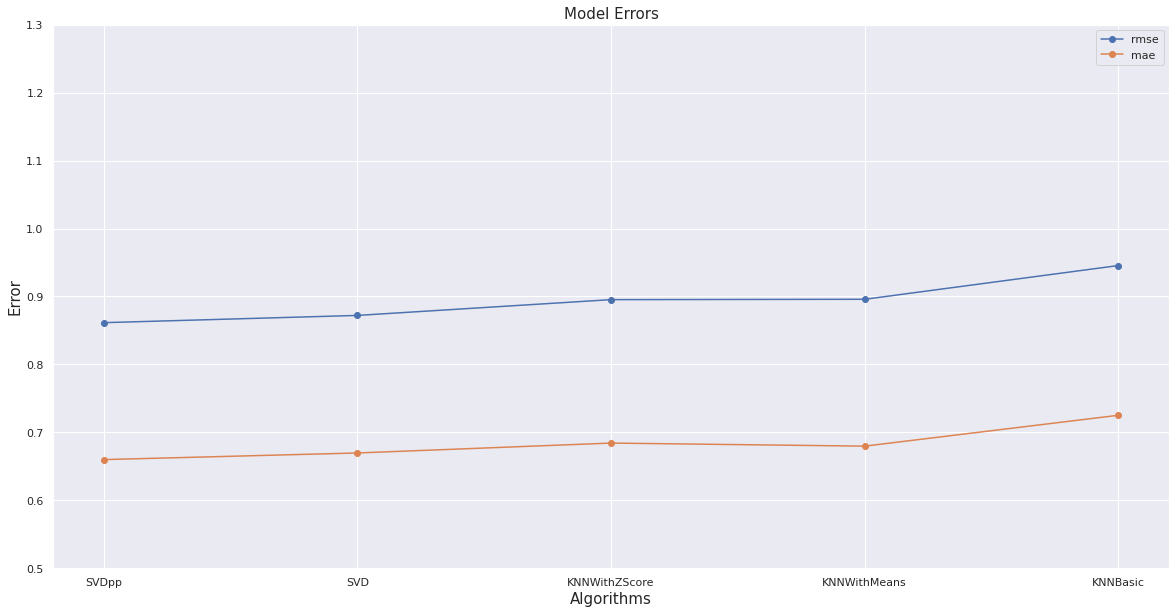

In [ ]:
# Get data
algo = ['SVDpp','SVD' , 'KNNWithZScore' ,'KNNWithMeans','KNNBasic' ]
rmse = surprise_results['test_rmse']
mae = surprise_results['test_mae']
x = np.arange(len(surprise_results))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize = (20, 10))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0.5, 1.3)
ax.plot(algo, rmse, marker='o', label="rmse")
ax.plot(algo, mae, marker='o', label="mae")

# Chart setup
plt.title("Model Errors", fontsize = 15)
plt.xlabel("Algorithms", fontsize = 15)
plt.ylabel("Error", fontsize = 15)
plt.legend()
plt.show()

I choise two standard errors as our evaluation metrics:

**Mean Absolute Error(MAE)** computes the avarage of all the absolute value differences between the true and the predicted rating.

**Root Mean Square Error(RMSE)** computes the mean value of all the differences squared between the true and the predicted ratings and then proceeds to calculate the square root out of the result.

For both of these metrics, lower the error better the accuracy.

SVDpp algorithm gave the best RMSE, While SVDpp had the better performance, tuning SVDpp takes considerably longer time to train compared to the naive SVD.So, I chose to optimize the SVD model for number of epochs, learning rate and regularization using grid search

### Tuning the Algorithm Parameters for SVD

In [ ]:
# two of the most important hyperparameters when running the stochastic gradient descent (SGD) algorithm are 
# learning rate and number of epochs.Thus I will tune this params
param_grid = {
    'n_epochs': [5, 10, 20, 30],            #The number of iteration of the SGD procedure. Default is 20
    'lr_all': [.0025, .005, .001, .01],     #The learning rate for all parameters. Default is 0.005
    'reg_all': [0.02, 0.04, 0.1, 0.2]       # The regularization term for all parameters. Default is 0.02

}      
# algo = SVD()
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5, n_jobs = -1,joblib_verbose=5) # From my experience , n_jobs = -1 executed faster than default
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min


0.855199034916331
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.8min finished


Based on our hyperparameter tuning, the best Matrix factorization based model that we found out was:

**RMSE:** 0.8548 which is better than untuned SVDpp

**Best Params:** number of epochs = 30 , learning rate = 0.01 , and regularization =0.1

In [ ]:
param_grid2 = {
    'n_epochs': [30, 40, 50],            #The number of iteration of the SGD procedure. Default is 20
    'lr_all': [.007,.01 , .015 ],        #The learning rate for all parameters. Default is 0.005
    'reg_all': [0.07, 0.1 , 0.3]         # The regularization term for all parameters which is a penalty term added to prevent overfitting. Default is 0.02

}      
# algo = SVD()
gs2 = GridSearchCV(SVD, param_grid2, measures=["rmse", "mae"], cv=5,n_jobs = -1,joblib_verbose=5)
gs2.fit(data)

print(gs2.best_score['rmse'])
print(gs2.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   53.4s


0.8503715097037494
{'n_epochs': 50, 'lr_all': 0.015, 'reg_all': 0.1}


[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  2.2min finished


**RMSE:** 0.8493

**Best Params:** number of epochs = 50 , learning rate = 0.015 , and regularization = 0.1

I got better result i will keep tuning till improvoment stop.

In [ ]:
param_grid3 = {
    'n_epochs': [50,60],                      #The number of iteration of the SGD procedure. Default is 20
    'lr_all': [.015 , 0.2 , 0.5, 0,7],        #The learning rate for all parameters. Default is 0.005
    'reg_all': [0.1]                          # The regularization term for all parameters.
                                                # which is a penalty term added to prevent overfitting Default is 0.02

}      
# algo = SVD()
gs3 = GridSearchCV(SVD, param_grid3, measures=["rmse", "mae"], cv=5,n_jobs = -1,joblib_verbose=5)
gs3.fit(data)

print(gs3.best_score['rmse'])
print(gs3.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.1s


0.8491733889548673
{'n_epochs': 50, 'lr_all': 0.015, 'reg_all': 0.1}


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


**RMSE:** 0.8495

**Best Params:** number of epochs = 45 , learning rate = 0.015 , and regularization = 0.1

It didnt make it better result So I will stop here and start predicting.

### Predictions

I use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. I’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [ ]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

In [ ]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n') 



Number of users:  610 

Number of items:  8746 



In [ ]:
svd = SVD(n_epochs=30, lr_all=0.01, reg_all=0.1)
svd.fit(trainset)
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8569


0.856936361435199

In [ ]:
chosen_svd = SVD(n_epochs=50, lr_all=0.015, reg_all=0.1)
chosen_svd.fit(trainset)
predictions = chosen_svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8515
0.8514538960287283


That would mean the estimated ratings on average are about 0.8525 higher or lower than the actual ratings, on a 0 to 5 scale

In [ ]:
predictions[:10]

[Prediction(uid=105, iid=7347, r_ui=4.0, est=3.720285607448477, details={'was_impossible': False}),
 Prediction(uid=335, iid=356, r_ui=4.0, est=4.189966540717784, details={'was_impossible': False}),
 Prediction(uid=393, iid=4720, r_ui=3.0, est=3.8519381658204264, details={'was_impossible': False}),
 Prediction(uid=567, iid=138036, r_ui=3.0, est=2.3219422872649798, details={'was_impossible': False}),
 Prediction(uid=274, iid=2448, r_ui=3.5, est=2.7013887255688958, details={'was_impossible': False}),
 Prediction(uid=91, iid=500, r_ui=2.5, est=3.210069566036405, details={'was_impossible': False}),
 Prediction(uid=140, iid=4921, r_ui=4.0, est=3.5586616486511833, details={'was_impossible': False}),
 Prediction(uid=96, iid=1, r_ui=5.0, est=3.8468006851521306, details={'was_impossible': False}),
 Prediction(uid=169, iid=4994, r_ui=4.5, est=4.076208977550929, details={'was_impossible': False}),
 Prediction(uid=318, iid=98809, r_ui=4.0, est=3.8755429384107627, details={'was_impossible': False})

In [ ]:
predictions_df = pd.DataFrame(predictions)
predictions_df

,uid,iid,r_ui,est,details
0,105,7347,4.0,3.720286,{'was_impossible': False}
1,335,356,4.0,4.189967,{'was_impossible': False}
2,393,4720,3.0,3.851938,{'was_impossible': False}
3,567,138036,3.0,2.321942,{'was_impossible': False}
4,274,2448,3.5,2.701389,{'was_impossible': False}
...,...,...,...,...,...
25204,140,527,5.0,3.933393,{'was_impossible': False}
25205,89,69757,2.5,3.161196,{'was_impossible': False}
25206,360,1721,4.0,3.775745,{'was_impossible': False}
25207,599,4386,1.0,2.540866,{'was_impossible': False}


### Make some predictions

In [ ]:
user1 = df[(df['userId'] == 1)]
user1

,userId,movieId,rating,title,genres,rated_movie,mean_rating
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215,3.920930
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,52,3.259615
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,102,3.946078
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,203,3.975369
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,204,4.237745
...,...,...,...,...,...,...,...
227,1,3744,4.0,Shaft (2000),Action|Crime|Thriller,19,2.657895
228,1,3793,5.0,X-Men (2000),Action|Adventure|Sci-Fi,133,3.699248
229,1,3809,4.0,What About Bob? (1991),Comedy,35,3.271429
230,1,4006,4.0,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi,7,3.357143


In [ ]:
user1= df[(df['userId'] == 1) & (df['movieId'] == 1)][['userId', 'movieId', 'rating', 'title']]
user1

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)


In [ ]:
chosen_svd.predict(1 ,1)

Prediction(uid=1, iid=1, r_ui=None, est=4.376367769767988, details={'was_impossible': False})

For movie with ID 1, we get an estimated prediction of 4.40 .It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

In [ ]:
user504 = df[(df['userId'] == 504)]
user504

,userId,movieId,rating,title,genres,rated_movie,mean_rating
80168,504,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215,3.920930
80169,504,22,3.5,Copycat (1995),Crime|Drama|Horror|Mystery|Thriller,36,3.222222
80170,504,186,3.0,Nine Months (1995),Comedy|Romance,48,2.822917
80171,504,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307,4.197068
80172,504,342,3.5,Muriel's Wedding (1994),Comedy,33,3.272727
...,...,...,...,...,...,...,...
80250,504,6953,4.0,21 Grams (2003),Crime|Drama|Mystery|Romance|Thriller,25,3.300000
80251,504,7139,4.5,In America (2002),Drama|Romance,7,3.857143
80252,504,7149,4.5,Something's Gotta Give (2003),Comedy|Drama|Romance,17,3.647059
80253,504,7151,4.0,Girl with a Pearl Earring (2003),Drama|Romance,12,3.375000


In [ ]:
chosen_svd.predict(504,1)

Prediction(uid=504, iid=1, r_ui=None, est=4.082764049121817, details={'was_impossible': False})

In [ ]:
user504= df[(df['userId'] == 504) & (df['movieId'] == 1)][['userId', 'movieId', 'rating', 'title']]
user504 

,userId,movieId,rating,title
80168,504,1,4.0,Toy Story (1995)


In [ ]:
chosen_svd.predict(504,1)

Prediction(uid=504, iid=1, r_ui=None, est=4.082764049121817, details={'was_impossible': False})

In [ ]:
user504= df[(df['userId'] == 504) & (df['movieId'] == 22)][['userId', 'movieId', 'rating', 'title']]
user504 

,userId,movieId,rating,title
80169,504,22,3.5,Copycat (1995)


In [ ]:
chosen_svd.predict(504,22)

Prediction(uid=504, iid=22, r_ui=None, est=3.4759910280345774, details={'was_impossible': False})

The field **est** indicates the estimated movie rating for this specific user.



In [ ]:
# uid = userid
# iid = movieid
# rui = true rating
# est = estimated movie rating
# details = Stores additional details about the prediction that might be useful for later analysis.
# err = est - rui

df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_pred['err'] = abs(df_pred.est - df_pred.rui)
df_pred.sort_values(by='err')

,uid,iid,rui,est,details,err
5160,584,356,5.0,5.000000,{'was_impossible': False},0.000000
23114,475,1198,5.0,5.000000,{'was_impossible': False},0.000000
10014,53,922,5.0,5.000000,{'was_impossible': False},0.000000
12169,30,318,5.0,5.000000,{'was_impossible': False},0.000000
19904,12,8533,5.0,5.000000,{'was_impossible': False},0.000000
...,...,...,...,...,...,...
6428,393,5902,0.5,4.384421,{'was_impossible': False},3.884421
19082,393,778,0.5,4.421655,{'was_impossible': False},3.921655
22358,594,5909,0.5,4.445121,{'was_impossible': False},3.945121
2883,154,130634,0.5,4.546909,{'was_impossible': False},4.046909


### Get the top-10 recommendations

In [ ]:
# https://surprise.readthedocs.io/en/stable/FAQ.html

from collections import defaultdict


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, r_ui, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


top_n = get_top_n(predictions, n=10)


In [ ]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
     print(uid, [iid for (iid, _) in user_ratings])

105 [2843, 170705, 55721, 48516, 83803, 3306, 4995, 6016, 858, 3147]
335 [318, 110, 593, 356, 3671, 592, 163, 2424, 2302]
393 [4993, 4011, 778, 5902, 59315, 58559, 4995, 53996, 4027, 1610]
567 [166291, 178827, 109487, 167746, 7361, 108932, 541, 260, 163645, 4144]
274 [5690, 7024, 30745, 1215, 8949, 48516, 2324, 3235, 78499, 175]
91 [1261, 541, 1249, 293, 1210, 5500, 318, 6874, 1291, 2571]
140 [3983, 356, 41863, 3741, 2889, 912, 527, 1270, 3359, 1344]
96 [1221, 1079, 110, 2028, 306, 3060, 1387, 1094, 2944, 480]
169 [2565, 6345, 6331, 1080, 4308, 1136, 2762, 2791, 7149, 5267]
318 [177593, 105197, 55721, 3038, 72226, 5379, 1222, 41863, 1273, 6440]
20 [595, 2080, 4246, 2565, 1022, 919, 364, 4027, 4865, 2085]
239 [8132, 1198, 2571, 48516, 4011, 1222, 3275, 3578, 16, 7147]
599 [8477, 6791, 3235, 1248, 83803, 2937, 4617, 898, 38095, 4103]
600 [2318, 5992, 247, 7084, 8949, 2502, 1394, 750, 26084, 1197]
477 [27156, 1283, 1222, 260, 2571, 4973, 7361, 55167, 48516, 2700]
68 [3653, 122918, 69757, 

In [ ]:
def get_movie_recommendations(user_id, preferred_genre = 'all'):
    
    new_df = df.copy()
    
    # filtering out by genre
    if preferred_genre !='all':
        new_df = new_df[new_df[preferred_genre]==1]
    
    # filtering out by number of ratings
    new_df = new_df[new_df['rated_movie']>= 50]
    
    # filtering out all movies already rated by user
    movies_already_watched = set(new_df[new_df['userId'] == user_id].movieId.values)
    new_df= new_df[~new_df['movieId'].isin(movies_already_watched)]
    
    # finding expected ratings for all remaining movies in the dataset
    all_movie_ids = set(new_df['movieId'].values)
    all_movie_ratings = []
    
    for i in all_movie_ids:
        expected_rating = chosen_svd.predict(uid=user_id, iid=i).est
        all_movie_ratings.append((i,round(expected_rating,1)))
        
    # extracting top ten movies by expected rating
    expected_df = pd.DataFrame(all_movie_ratings, columns=['movieId','Expected Rating'])    
    result_df = pd.merge(expected_df, df_[['movieId','title','genres','rated_movie']],on='movieId')
    # result_df = result_df[result_df['userId'] == user_id]
    result_df = result_df.sort_values(['Expected Rating','rated_movie'],ascending=[False,False])
    
    return result_df.head(10)



In [ ]:
# get movie recommendation for userid = 25
get_movie_recommendations(25)

,movieId,Expected Rating,title,genres,rated_movie
93,318,5.0,"Shawshank Redemption, The (1994)",Crime|Drama,317
87,296,4.9,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307
167,593,4.9,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279
279,1196,4.9,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,211
23,50,4.9,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,204
39,4226,4.9,Memento (2000),Mystery|Thriller,159
280,1197,4.9,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,142
278,1193,4.9,One Flew Over the Cuckoo's Nest (1975),Drama,133
294,7361,4.9,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,131
82,2329,4.9,American History X (1998),Crime|Drama,129


In [ ]:
# get movie recommendation for userid = 5
get_movie_recommendations(5)

,movieId,Expected Rating,title,genres,rated_movie
224,953,4.4,It's a Wonderful Life (1946),Children|Drama|Fantasy|Romance,58
290,1276,4.4,Cool Hand Luke (1967),Drama,57
214,912,4.3,Casablanca (1942),Drama|Romance,100
73,2324,4.3,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,88
277,1225,4.3,Amadeus (1984),Drama,76
391,6016,4.3,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,75
254,1193,4.2,One Flew Over the Cuckoo's Nest (1975),Drama,133
272,7361,4.2,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,131
275,1221,4.2,"Godfather: Part II, The (1974)",Crime|Drama,129
131,541,4.2,Blade Runner (1982),Action|Sci-Fi|Thriller,124


# Conclusion

In this notebook different recommendation approaches of
content and collaborative filtering has been discussed.

First, I did exploratory data analysis then I started with content based filtering to recommend movie to new user based upon genre and movie popularity or the average ratings given by other users in the database.


I then progressed collaborative filtering based engines which try to find similar movies or users to make their predictions. After assessing models on **RMSE** metric, I found SVD++ to be the most accurate model but since SVD++ hyperparameters tuning time consuming I decided to go with SVD model tuned hyperparameters by using GridSearchCV

Finally, I made a recommendation engine which recommends 10 movies to specific user by using SVD model. And I added filtering options for genre and minimum number of ratings to make recommendations more accurate

# Recommendations

- Most popular genres will be a relevant aspect to take into account when building the content based recommender.

- Collaborative Filtering Recommender Engine more effectively when it comes to recommend movies based on other users' preference but It doesn't solve the cold start problem. To help solve this problem we can use hybrid model of our naive recommendation engine and the model based recommendation engine.

- We optimized SVD model to prevent time consuming and cost but Optimizing SVDpp can be more efficient since SVDpp is an extension of SVD model which deals with both explicit feedback an implicit feedback

# Future Work

In this notebook there is a lot of potential to do but in the future, deep learning based recommender system can be built to enhance the
performance and provide better recommendations to
user.

# References

https://www.diva-portal.org/smash/get/diva2:1112342/FULLTEXT01.pdf

https://jusst.org/wp-content/uploads/2020/12/Comparative-Study-of-Machine-Learning-Algorithms-for-Recommendation.pdf

https://buomsoo-kim.github.io/recommender%20systems/2020/10/22/Recommender-systems-collab-filtering-14.md/

https://medium.com/fnplus/matrix-factorisation-d3cd9c4d820a

https://towardsdatascience.com/how-to-build-a-memory-based-recommendation-system-using-python-surprise-55f3257b2cf4



https://surprise.readthedocs.io/en/stable/FAQ.html